In [11]:
# process a video file and calculate the average frame

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
file = input("Enter the name of the video file: ")


# Prepare the figure
fig = plt.figure()
fig.set_size_inches(10, 10)

    # Open the video file
cap = cv2.VideoCapture(file)

# Initialize sum of frames
sum_frames = None
frame_count = 0

while True:
    # Read a frame
    ret, frame = cap.read()
    if not ret:
        break  # Exit the loop if no more frames

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add frame to sum
    if sum_frames is None:
        sum_frames = np.array(gray_frame, dtype=np.float32)
    else:
        sum_frames += gray_frame

    frame_count += 1

# Calculate average
avg_frame = sum_frames / frame_count

# Release the video file
cap.release()

# Normalize between 0 and 1
avg_frame = avg_frame / 255.0

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

plt.ioff()  # Turn interactive mode off


magnification = 38
pixel_pitch = 3.6 #um
scale_bar_length = 1.0 #um
scale_bar_pixels = scale_bar_length * magnification / pixel_pitch

# Assume `image` is your 2D numpy array image

# Find the location of the brightest pixel in the image
brightest_pixel = np.unravel_index(np.argmax(avg_frame), avg_frame.shape)

# Extract a line profile across the object
# For example, take a horizontal line profile through the brightest pixel
line_profile = avg_frame[brightest_pixel[0], :]

# Find the peak of the line profile
peak_index = np.argmax(line_profile)

# Compute the FWHM of the line profile
widths, height, left_ips, right_ips = scipy.signal.peak_widths(line_profile, [peak_index], rel_height=0.5)

# The FWHM is the width at half maximum
fwhm = widths[0]

fwhm_um = fwhm * pixel_pitch / magnification

# Plot the line profile and the FWHM
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 1].plot(line_profile)
axes[0, 1].plot([left_ips[0], right_ips[0]], [height[0], height[0]], 'ro-')
axes[0, 1].set_title("FWHM = {:.2f} pixels\n {:.2f} microns".format(fwhm, fwhm_um))
axes[0, 1].set_xlabel("Width (pixels)")
axes[0, 1].set_ylabel("Intensity")

# Plot the image
axes[0, 0].imshow(avg_frame, cmap='inferno')
axes[0, 0].set_title("Single Fluorophore".format(fwhm))

# Add a scale bar to the image
# The scale bar is 1um long


# Draw the scale bar in the bottom right corner
axes[0, 0].plot([avg_frame.shape[1] - scale_bar_pixels - 30, avg_frame.shape[1] - 30], [avg_frame.shape[0] - 20, avg_frame.shape[0] - 20], 'w-', lw=3)

# Add the scale bar label
axes[0, 0].text(avg_frame.shape[1] - scale_bar_pixels - 10, avg_frame.shape[0] - 80, "1.0 um", color='w', ha='right', va='top')


Text(1259.4444444444443, 944, '1.0 um')

In [23]:
from metavision_ml.preprocessing import histo
from metavision_ml.preprocessing.viz import filter_outliers
import numpy as np
import matplotlib.pyplot as plt

from common import helpers

record = helpers.load_evts_from_file(input('Raw File: '), delta_t=1e6, start_ts=1e6)
height, width = record.get_size()
print('record dimensions: ', height, width)
#start_ts = 100

#delta_t = 5e6 #sampling duration
#events = record.load_delta_t(delta_t)  # load 50 milliseconds worth of events
events = next(iter(record))
events['t'] -= int(1e6) # important! almost all preprocessing use relative time!

volume = np.zeros((2, 2, height, width))
histo(events, volume, 1e6)

avg_volume = np.mean(volume[:, 1], axis=0)

record dimensions:  480 640


C:\Users\User\AppData\Local\Temp\ipykernel_11064\3885387494.py:12: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labels, num_labels = scipy.ndimage.measurements.label(avg_volume)
C:\Users\User\AppData\Local\Temp\ipykernel_11064\3885387494.py:14: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center_of_mass = scipy.ndimage.measurements.center_of_mass(labels == largest_cluster_label)


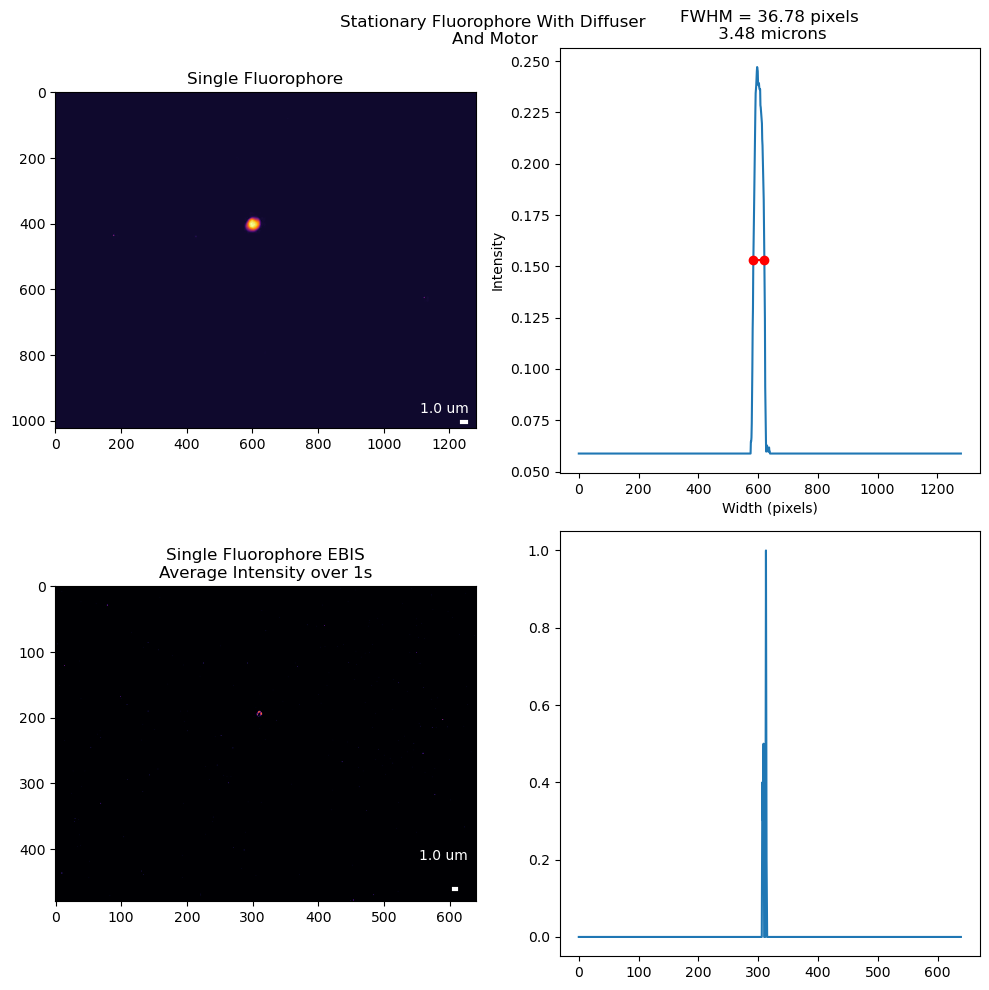

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.measurements

magnification = 38
pixel_pitch = 15 #um
scale_bar_length = 1.0 #um
scale_bar_pixels = scale_bar_length * magnification / pixel_pitch

# Assume `image` is your 2D numpy array image

labels, num_labels = scipy.ndimage.measurements.label(avg_volume)
largest_cluster_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
center_of_mass = scipy.ndimage.measurements.center_of_mass(labels == largest_cluster_label)

# Use the y-coordinate of the center of mass as the x-coordinate for the line profile
x_coordinate = int(center_of_mass[0])
line_profile = avg_volume[x_coordinate, :]
axes[1, 1].plot(line_profile)

# Find the peak of the line profile
peak_value = np.max(line_profile)
half_peak_value = peak_value / 2

# Find all spikes that rise to more than half of the peak value
spikes = np.where(line_profile > half_peak_value)[0]
if len(spikes) >= 2:
    # Find the farthest two spikes
    farthest_spikes = [np.min(spikes), np.max(spikes)]

    # Calculate the FWHM based on the farthest spikes
    fwhm = farthest_spikes[1] - farthest_spikes[0]
    fwhm_um = fwhm * pixel_pitch / magnification

# Plot the line profile and the points at the halfway point of the farthest two spikes
if len(spikes) >= 2:
    axes[1, 1].plot(farthest_spikes, [half_peak_value, half_peak_value], 'ro-')
    axes[1, 1].set_title("FWHM = {:.2f} pixels\n {:.2f} microns".format(fwhm, fwhm_um))
    axes[1, 1].set_xlabel("Width (pixels)")
    axes[1, 1].set_ylabel("Intensity")

# The rest of the code remains the same
# Add a scale bar to the avg_volume
# The scale bar is 1um long

axes[1, 0].imshow(avg_volume, cmap='inferno')
axes[1, 0].set_title("Single Fluorophore EBIS\nAverage Intensity over 1s".format(fwhm))
# Draw the scale bar in the bottom right corner
axes[1, 0].plot([avg_volume.shape[1] - scale_bar_pixels - 30, avg_volume.shape[1] - 30], [avg_volume.shape[0] - 20, avg_volume.shape[0] - 20], 'w-', lw=3)

# Add the scale bar label
axes[1, 0].text(avg_volume.shape[1] - scale_bar_pixels - 10, avg_volume.shape[0] - 80, "1.0 um", color='w', ha='right', va='top')
plt.tight_layout()
fig.suptitle('Stationary Fluorophore With Diffuser \nAnd Motor')
plt.show()


In [5]:
plt.imsave('avg_volume.png', avg_volume, cmap='inferno')